# **Hands-on: molecular data reading**

- Author: Tales Miguel Machado Pereira
- RA: 140247
- Professor: Dr. Marcos Quiles

### **1.Load and unpack the QM9 dataset**

[Data for 133885 GDB-9 molecules](https://springernature.figshare.com/articles/dataset/Data_for_6095_constitutional_isomers_of_C7H10O2/1057646?backTo=%2Fcollections%2FQuantum_chemistry_structures_and_properties_of_134_kilo_molecules%2F978904&file=3195389)

#### **1.1. About the Dataset**

"Molecular structures and properties are publicly available at Figshare (Data Citation 1) in a plain text XYZ-like format described below. Deposited files include the 133, 885 GDB-1 to GDB-9 molecules (dsgdb9nsd.xyz.tar.bz2), the 6,095 constitutional isomers of C7H10O2 (dsC7O2H10nsd.xyz.tar.bz2), the 100 validation molecules (see Table 1) enthalpies of atomization (validation.txt), and atomic reference data (atomref.txt)."

[Ramakrishnan, R., Dral, P., Rupp, M. et al. Quantum chemistry structures and properties of 134 kilo molecules. Sci Data 1, 140022 (2014).](https://www.nature.com/articles/sdata201422#Sec4)

#### **1.2. General structure of QM9 XYZ files**

- Line 1: Number of atoms in the molecule

- Line 2: Extended header with computed molecular properties (16 values):
    1. gdb ID - Database identifier
    2. A - Rotational constant A (GHz)
    3. B - Rotational constant B (GHz)
    4. C - Rotational constant C (GHz)
    5. μ - Dipole moment (Debye)
    6. α - Isotropic polarizability (Bohr³)
    7. εHOMO - Energy of Highest Occupied Molecular Orbital (Hartree)
    8. εLUMO - Energy of Lowest Unoccupied Molecular Orbital (Hartree)
    9. Δε - Gap between HOMO and LUMO (Hartree)
    10. 〈R²〉 - Electronic spatial extent (Bohr²)
    11. zpve - Zero point vibrational energy (Hartree)
    12. U₀ - Internal energy at 0K (Hartree)
    13. U - Internal energy at 298.15K (Hartree)
    14. H - Enthalpy at 298.15K (Hartree)
    15. G - Free energy at 298.15K (Hartree)
    16. Cv - Heat capacity at 298.15K (cal/mol·K)

- Lines 3 to N+2: Atomic coordinates and charges (5 columns):
    1. Element symbol - Chemical element (C, H, N, O, etc.)
    2. x coordinate - Position in Angstroms
    3. y coordinate - Position in Angstroms
    4. z coordinate - Position in Angstroms
    5. Partial charge - Mulliken partial charge (electrons)
    
- Line N+3: Harmonic vibrational frequencies (cm⁻¹) - varies by molecule size

- Line N+4: Mulliken charges by atom type

- Lines N+5 & N+6: InChI strings for chemical identification and verification

In [1]:
import tarfile

def unpack_database(db_path='db/dsgdb9nsd.xyz.tar.bz2', dest_path='db/qm9_unpacked'):
    """
    Unpack 
    """
    # Unpack the tar.bz2 file
    with tarfile.open(db_path, 'r:bz2') as tar:
        tar.extractall(path=dest_path)

    print(f"\nDatabase unpacked to {dest_path}")


# Path to the tar.bz2 file inside the db folder
db_path = 'db/dsgdb9nsd.xyz.tar.bz2'
dest_path = 'db/qm9_unpacked'
unpack_database(db_path, dest_path)

/tmp/ipykernel_29268/3539781899.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest_path)



Database unpacked to db/qm9_unpacked


### **2.XYZ File Parser**

In [2]:
import os
import glob
import pandas as pd
from rdkit import Chem # SMILES validation
import warnings
warnings.filterwarnings('ignore')

In [3]:
def parse_xyz_file(file_path):
    """Parse QM9 XYZ file and extract molecular properties and SMILES."""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    n_atoms = int(lines[0])

    # header_parts = lines[1].split('\t')
    
    # SMILES is located at the penultimate line
    smiles = lines[-2].split('\t')[0]  # duplicated SMILES entries for some reason, taking the first one
    
    # Extract all 16 molecular properties from the header line
    properties = [
        'gdb_id', 'rot_const_A', 'rot_const_B', 'rot_const_C', 'dipole_moment',
        'isotropic_polarizability', 'homo_energy', 'lumo_energy', 'homo_lumo_gap',
        'electronic_spatial_extent', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
    ]

    header_values = lines[1].split()
    # If the first value is not a digit, skip it (e.g., 'gdb')
    if not header_values[0].isdigit():
        header_values = header_values[1:]

    # Mapping property names to their values
    data = {name: int(val) if name == 'gdb_id' else float(val) 
            for name, val in zip(properties, header_values)}
    
    data['n_atoms'] = n_atoms
    data['smiles'] = smiles
    return data

In [4]:
def validate_and_canonicalize_smiles(smiles):
    """Validate SMILES and generate canonical version."""
    # Validate original SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, False
    
    # Generate canonical SMILES
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    
    return canonical_smiles, True

In [5]:
def process_xyz_files(directory_path, max_files=None):
    """Process XYZ files and extract SMILES and properties."""
    xyz_files = sorted(glob.glob(os.path.join(directory_path, "*.xyz")))
    
    if max_files:
        xyz_files = xyz_files[:max_files]
    
    results = []
    
    for file_path in xyz_files:
        # Parse XYZ file (SMILES already included)
        data = parse_xyz_file(file_path)
        
        # Validate and canonicalize SMILES
        canonical_smiles, is_valid = validate_and_canonicalize_smiles(data['smiles'])
        
        # Only keep valid molecules
        if is_valid:
            data['canonical_smiles'] = canonical_smiles
            results.append(data)
    
    return pd.DataFrame(results)

In [6]:
df = process_xyz_files('db/qm9_unpacked')
df.to_csv('qm9_complete_dataset.csv', index=False)
print(f"Processed {len(df)} molecules")

Processed 133885 molecules


### **3. Data Visualization**

Visualizing the distribution of all molecular properties in the dataset.

#### 3.1. Histogram plot for all properties

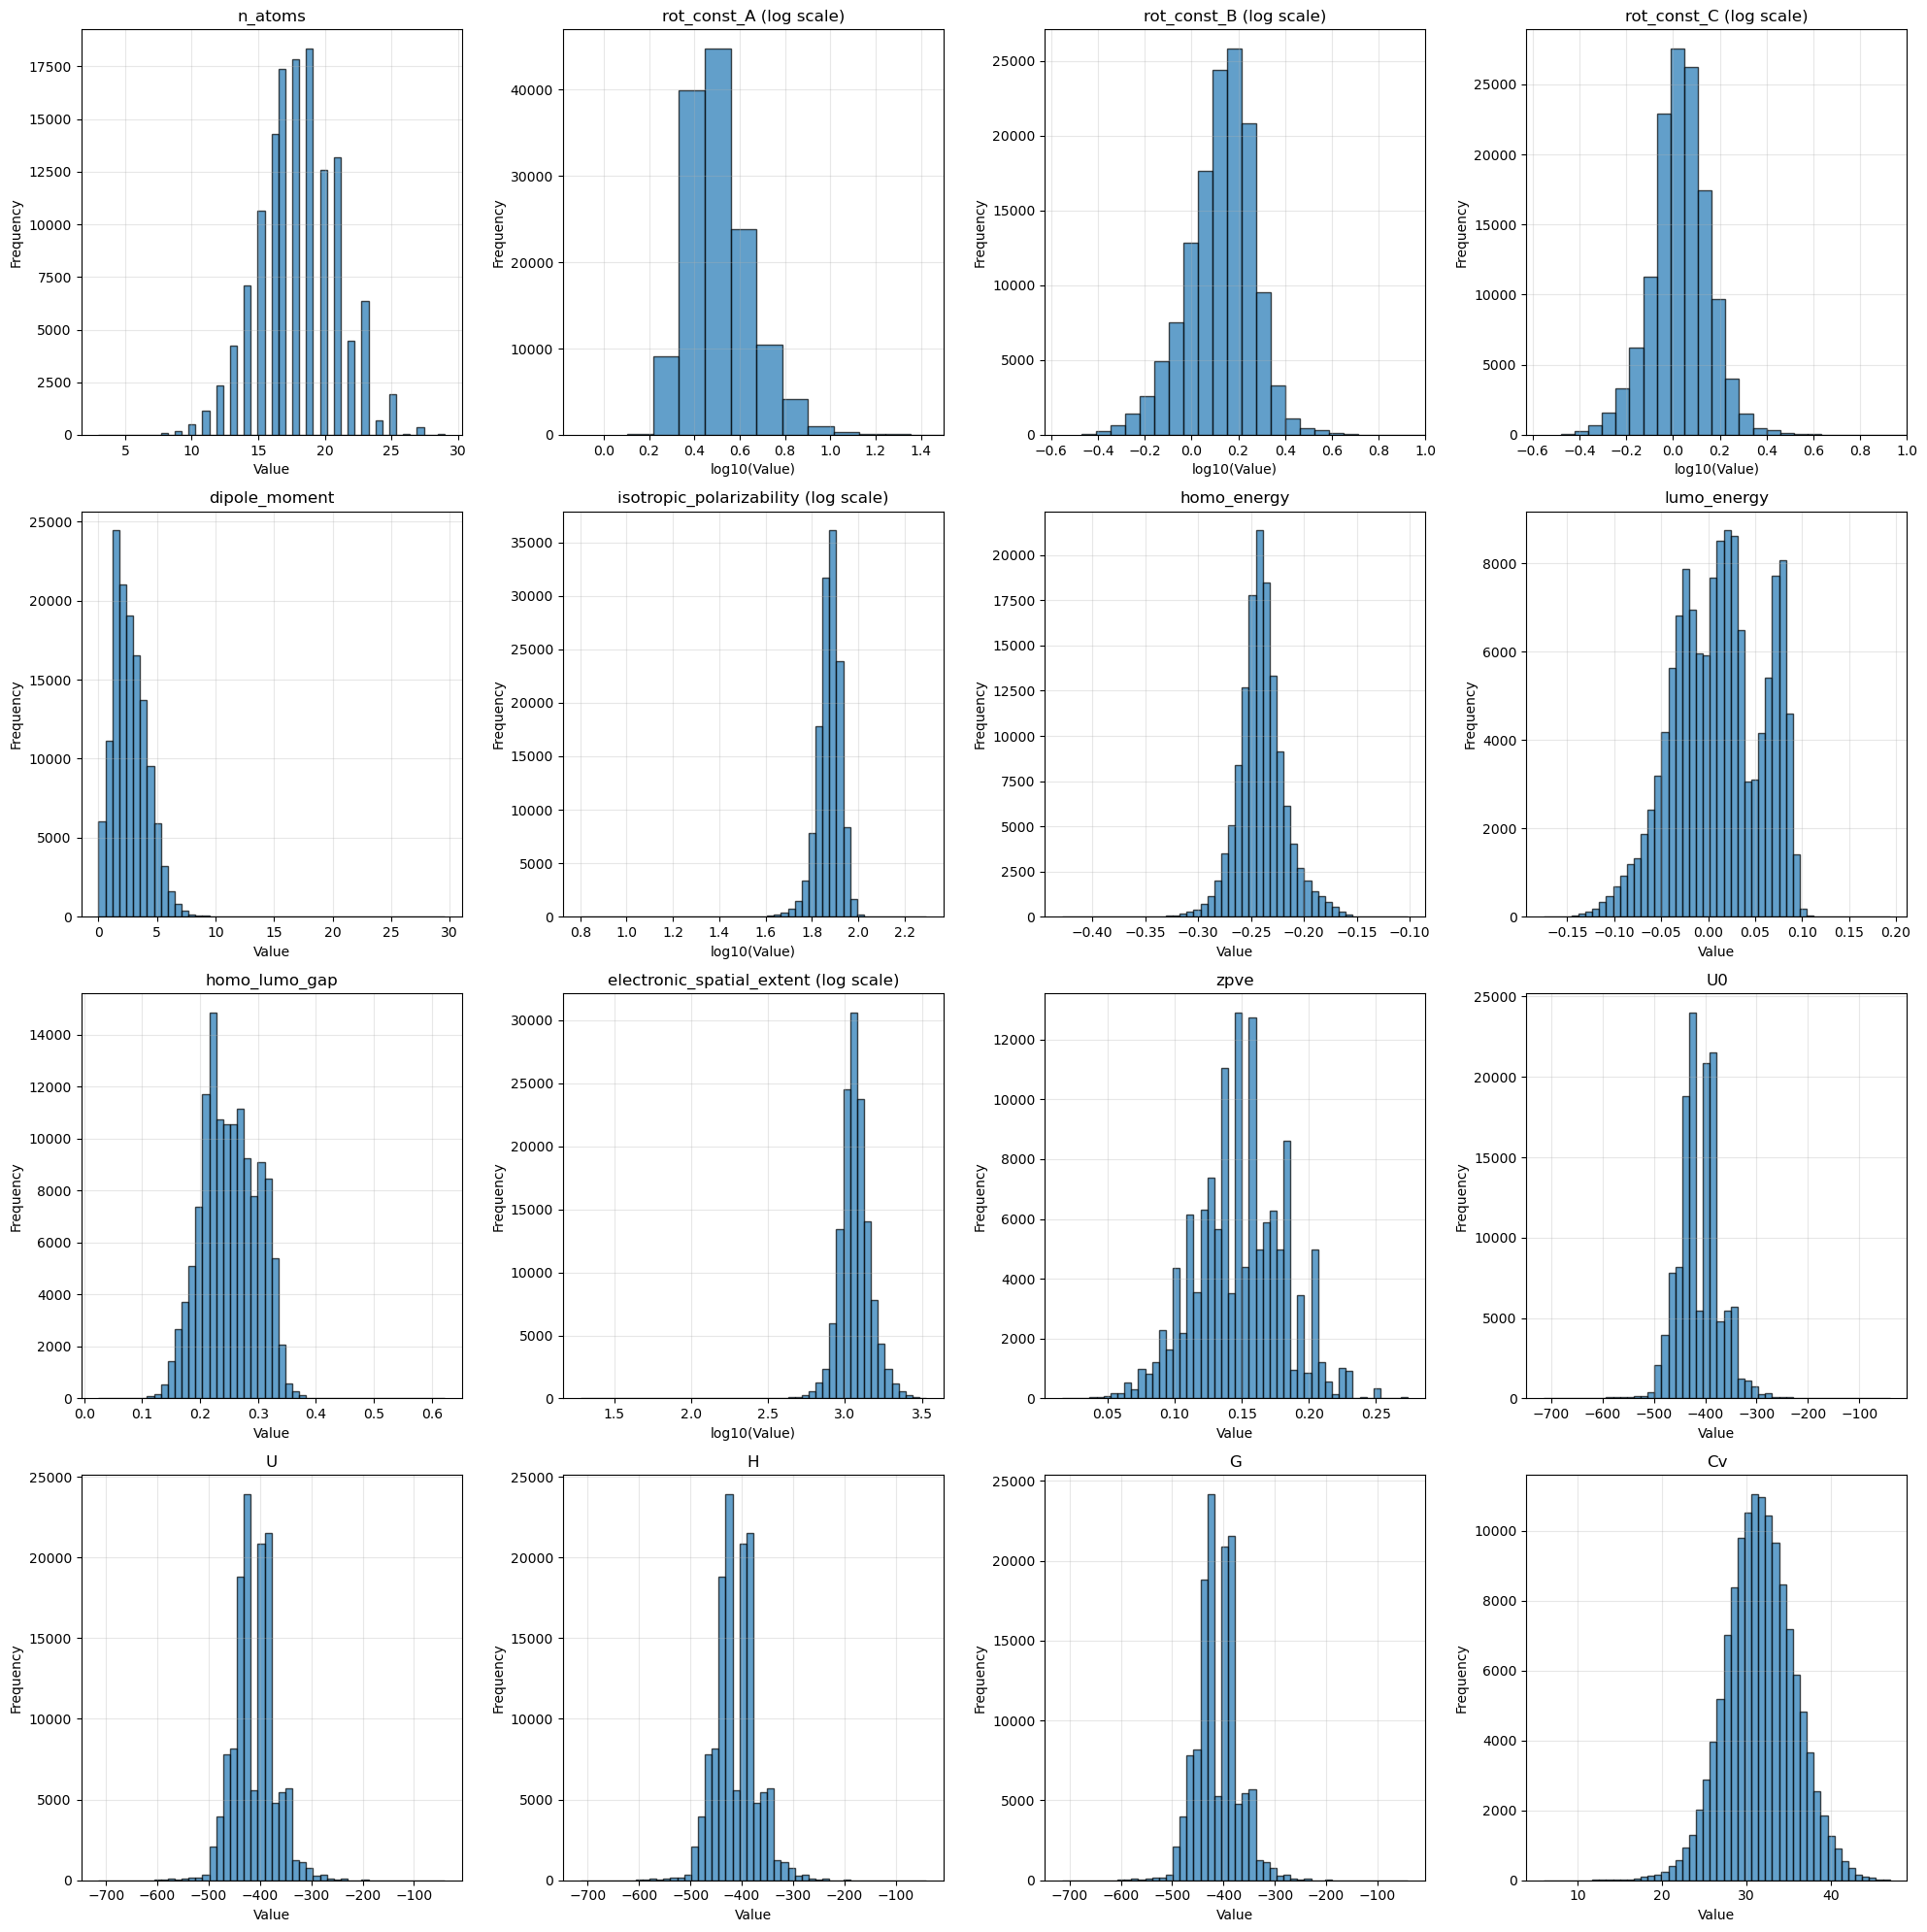


Summary Statistics:
n_atoms:
  Mean: 17.9837
  Std:  2.9543
  Min:  3.0000
  Max:  29.0000

rot_const_A:
  Mean: 9.8144
  Std:  1809.4657
  Min:  0.0000
  Max:  619867.6831
  Geometric Mean: 3.2254
  Zeros: 9 molecules

rot_const_B:
  Mean: 1.4061
  Std:  1.5838
  Min:  0.3371
  Max:  437.9039
  Geometric Mean: 1.3269
  Zeros: 0 molecules

rot_const_C:
  Mean: 1.1249
  Std:  1.0956
  Min:  0.3312
  Max:  282.9454
  Geometric Mean: 1.0750
  Zeros: 0 molecules

dipole_moment:
  Mean: 2.7060
  Std:  1.5304
  Min:  0.0000
  Max:  29.5564

isotropic_polarizability:
  Mean: 75.1913
  Std:  8.1878
  Min:  6.3100
  Max:  196.6200
  Geometric Mean: 74.7184
  Zeros: 0 molecules

homo_energy:
  Mean: -0.2400
  Std:  0.0221
  Min:  -0.4286
  Max:  -0.1017

lumo_energy:
  Mean: 0.0111
  Std:  0.0469
  Min:  -0.1750
  Max:  0.1935

homo_lumo_gap:
  Mean: 0.2511
  Std:  0.0475
  Min:  0.0246
  Max:  0.6221

electronic_spatial_extent:
  Mean: 1189.5274
  Std:  279.7572
  Min:  19.0002
  Max:  3374.75

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Properties to plot (excluding gdb_id and smiles/canonical_smiles)
numeric_properties = [
    'n_atoms', 'rot_const_A', 'rot_const_B', 'rot_const_C', 
    'dipole_moment', 'isotropic_polarizability', 'homo_energy', 'lumo_energy', 
    'homo_lumo_gap', 'electronic_spatial_extent', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]

# Properties that benefit from log scale (wide ranges, many zeros)
log_scale_properties = ['rot_const_A', 'rot_const_B', 'rot_const_C', 'isotropic_polarizability', 'electronic_spatial_extent']

# X-axis limits for specific properties (in log scale)
xlim_dict = {
    'rot_const_A': (None, 1.5),    # limit to log10 = 1.5 (31.62 GHz)
    'rot_const_B': (None, 1),    # limit to log10 = 1 (10 GHz)
    'rot_const_C': (None, 1)     # limit to log10 = 1 (10 GHz)
}

# Create subplots
n_properties = len(numeric_properties)
n_cols = 4
n_rows = (n_properties + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plot histogram for each property
for i, prop in enumerate(numeric_properties):
    if prop in df.columns:
        data = df[prop]
        
        # Use log scale for properties with wide ranges
        if prop in log_scale_properties:
            # Filter out zeros and negative values for log scale
            data_filtered = data[data > 0]
            if len(data_filtered) > 0:
                axes[i].hist(np.log10(data_filtered), bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_xlabel('log10(Value)')
                axes[i].set_title(f'{prop} (log scale)')
                
                # Set x-axis limits if specified
                if prop in xlim_dict:
                    axes[i].set_xlim(xlim_dict[prop])
            else:
                axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_xlabel('Value')
                axes[i].set_title(f'{prop}')
        else:
            axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_xlabel('Value')
            axes[i].set_title(f'{prop}')
        
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{prop}\nNot available', 
                    transform=axes[i].transAxes, ha='center', va='center')
        axes[i].set_title(f'{prop} (Missing)')

# Hide unused subplots
for i in range(n_properties, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for prop in numeric_properties:
    if prop in df.columns:
        data = df[prop]
        print(f"{prop}:")
        print(f"  Mean: {data.mean():.4f}")
        print(f"  Std:  {data.std():.4f}")
        print(f"  Min:  {data.min():.4f}")
        print(f"  Max:  {data.max():.4f}")
        
        # Show additional stats for log-scale properties
        if prop in log_scale_properties:
            data_positive = data[data > 0]
            if len(data_positive) > 0:
                print(f"  Geometric Mean: {np.exp(np.log(data_positive).mean()):.4f}")
                print(f"  Zeros: {len(data) - len(data_positive)} molecules")
        print()

#### 3.2. Plotting histograms for the molecular composition and size